In [1]:
import xskillscore
import xarray as xr
from datetime import datetime, timedelta
import h5py as h5
import pandas as pd
from modulus.metrics.general import crps
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm


plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

In [2]:
import torch
dummy = xr.open_dataset("/dvs_ro/cfs/cdirs/m1517/cascade/amahesh/hens/HENS_summer23_20230814T000000/ensemble_out_00001_2023-08-14-00-00-00.nc",
                       group='global')

In [3]:
def wrap_fin(fin, ensemble_size):
    out = xr.DataArray(fin,
                       dims=('lead_time', 'ensemble_size', 'lat', 'lon'),
                       coords=({'lat' : dummy['lat'],
                                'lon' : dummy['lon'],
                                'ensemble_size' : [7424, 58],
                                'lead_time' : np.array([16,17,18,19,28,29,30,31,40,41,42,43]) * pd.Timedelta('6H')}))
    # out = out.sel(lat=slice(60,-60))
    weights = np.cos(np.deg2rad(out.lat))
    # return out.sel(ensemble_size=ensemble_size)
    return out.weighted(weights).mean(('lat', 'lon')).sel(ensemble_size=ensemble_size)

In [7]:
def convert_nan_to_0(da):
    return np.where(np.isnan(da), 0, da)

In [15]:
dates = pd.date_range('2023-06-01', '2023-08-31')
# dates = pd.date_range('2023-08-13', '2023-08-31')

small_crps, small_owcrps, small_twcrps = [], [], []
hens_crps, hens_owcrps, hens_twcrps = [], [], []

#COMMENT OUT CONVERT_NAN_TO_0 method if you want to only apply owCRPS when the extreme occurs.  With this method, an owCRPS value of 0 is used when no extreme occurs.
#Without the method, there will be no penalty of no owCRPS.

for idx, date in enumerate(dates):
    fin = h5.File(f"/pscratch/sd/a/amahesh/hens_h5/nobootstrap_percentile_and_crps/percentile95_t2m_{date:%Y%m%d}_reduced-lead-04-07-10.h5", "r")
    small_owcrps.append(wrap_fin(convert_nan_to_0(fin['t2m_owcrps'][idx]), ensemble_size=58))
    small_twcrps.append(wrap_fin(fin['t2m_twcrps'][idx], ensemble_size=58))
    small_crps.append(wrap_fin(fin['t2m_crps'][idx], ensemble_size=58))
    
    hens_owcrps.append(wrap_fin(convert_nan_to_0(fin['t2m_owcrps'][idx]), ensemble_size=7424))
    hens_twcrps.append(wrap_fin(fin['t2m_twcrps'][idx], ensemble_size=7424))
    hens_crps.append(wrap_fin(fin['t2m_crps'][idx], ensemble_size=7424))
    print(idx)
    fin.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


In [16]:
small_owcrps = xr.concat(small_owcrps, dim='initial_time')
small_twcrps = xr.concat(small_twcrps, dim='initial_time')
small_crps = xr.concat(small_crps, dim='initial_time')

hens_owcrps = xr.concat(hens_owcrps, dim='initial_time')
hens_twcrps = xr.concat(hens_twcrps, dim='initial_time')
hens_crps = xr.concat(hens_crps, dim='initial_time')

/tmp/ipykernel_945344/2201242388.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis')


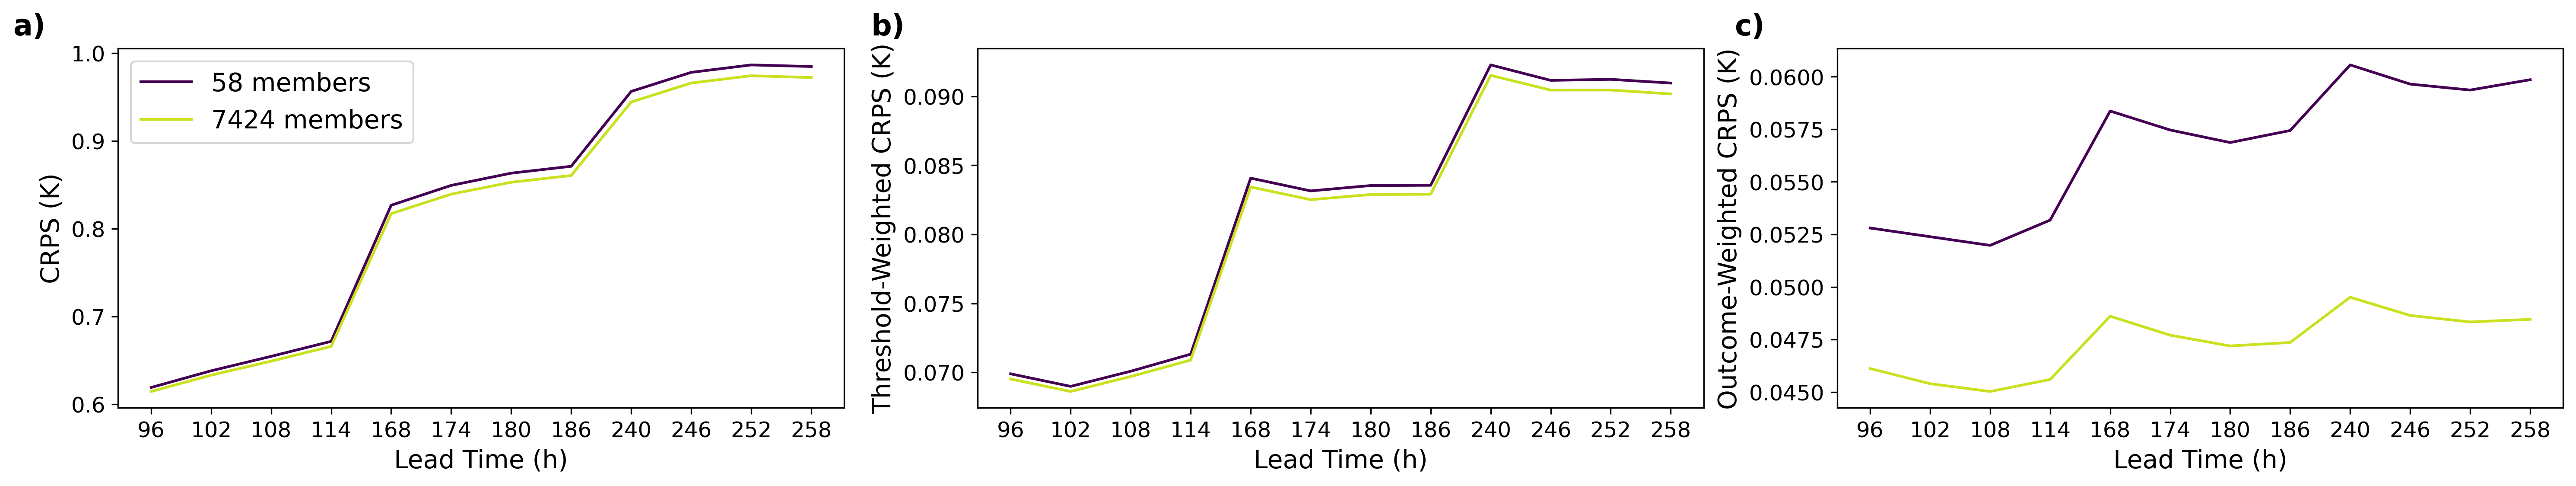

In [23]:
fig, (ax3, ax2, ax1) = plt.subplots(1, 3, dpi=300, figsize=(20,4))
viridis = cm.get_cmap('viridis')

# Get the extreme colors from the colormap
color_58_members = viridis(0)  # First color in viridis
color_7424_members = viridis(235)  # Last color in viridis

ax1.plot(small_owcrps.mean('initial_time').values, label='58 members', color=color_58_members)
ax1.plot(hens_owcrps.mean('initial_time').values, label='7424 members', color=color_7424_members)

ax1.set_xticks(np.arange(12), labels= np.array([16,17,18,19,28,29,30,31,40,41,42,43])*6)
ax1.set_xlabel("Lead Time (h)")
ax1.set_ylabel("Outcome-Weighted CRPS (K)")

ax2.plot(small_twcrps.mean('initial_time').values, label='58 members', color=color_58_members)
ax2.plot(hens_twcrps.mean('initial_time').values, label='7424 members', color=color_7424_members)

ax2.set_xticks(np.arange(12), labels= np.array([16,17,18,19,28,29,30,31,40,41,42,43])*6)
ax2.set_xlabel("Lead Time (h)")
ax2.set_ylabel("Threshold-Weighted CRPS (K)")

ax3.plot(small_crps.mean('initial_time').values, label='58 members', color=color_58_members)
ax3.plot(hens_crps.mean('initial_time').values, label='7424 members', color=color_7424_members)

ax3.set_xticks(np.arange(12), labels= np.array([16,17,18,19,28,29,30,31,40,41,42,43])*6)
ax3.set_xlabel("Lead Time (h)")
ax3.set_ylabel("CRPS (K)")
ax3.legend()

ax1.text(-0.1, 1.1, 'c)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.text(-0.1, 1.1, 'a)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.subplots_adjust(wspace=0.4)  # Adjust whitespace between plots
plt.tight_layout()

plt.savefig("crps_hens_vs_small_comparison.pdf")